In [ ]:
"""
To Analyze the 


"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")
%matplotlib inline

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import dimensionality_reduction_utils as dr
import clustering_utils as cl
dr = reload(dr)
cl = reload(cl)
import pandas_utils as pu

from sklearn.preprocessing import StandardScaler
import time
from collections import Counter
import copy
np.set_printoptions(suppress=True)

In [3]:
df = pd.read_pickle("neuron_dendrite_path_data")
df_filtered = pu.filter_away_nan_rows(df)

# Get the distribution of the limb starts 

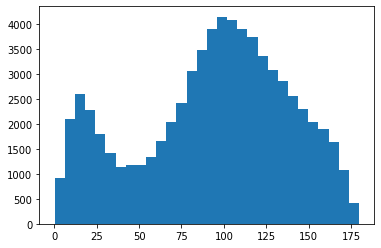

In [4]:
soma_angles =df_filtered[::4]["soma_angle"].to_numpy()
bin_data = plt.hist(soma_angles,bins=30)

# Extracting the Vectors we want to process (not excluding the soma angle)

In [5]:
columns_picked = df_filtered.columns[6:].to_numpy()
columns_picked

array(['n0_width_median_mesh_center',
       'n0_width_no_spine_median_mesh_center', 'n0_n_spines',
       'n0_total_spine_volume', 'n0_spine_volume_median',
       'n0_spine_volume_density', 'n0_skeletal_length', 'n0_parent_angle',
       'n0_sibling_angle', 'n1_width_median_mesh_center',
       'n1_width_no_spine_median_mesh_center', 'n1_n_spines',
       'n1_total_spine_volume', 'n1_spine_volume_median',
       'n1_spine_volume_density', 'n1_skeletal_length', 'n1_parent_angle',
       'n1_sibling_angle'], dtype=object)

In [ ]:
# def normalized_data(df_curr,picked_columns):
#     df_data = df_curr[columns_picked].to_numpy()
#     df_data_scaled = StandardScaler().fit_transform(df_data)
#     df_scaled = pd.DataFrame(df_data_scaled)
#     #add on the columns
#     df_scaled.columns = picked_columns
#     return df_scaled

In [6]:
df_data = df_filtered[columns_picked].to_numpy()
scaler = StandardScaler()
df_data_scaled = scaler.fit_transform(df_data)
df_data_reversed = scaler.inverse_transform(df_data_scaled,copy=True)

data_df_normalized = pd.DataFrame(df_data_scaled)
#add on the columns
data_df_normalized.columns = columns_picked


In [9]:
df_data_reversed

array([[  192.16,   192.16,     0.  , ..., 70666.48,    13.53,    96.8 ],
       [  192.16,   192.16,     0.  , ..., 12721.84,    84.41,    96.8 ],
       [   83.79,    83.79,     0.  , ...,  5910.65,    29.57,    31.68],
       ...,
       [  396.01,   396.01,     2.  , ..., 76418.71,    60.77,    58.52],
       [  327.06,   313.81,    23.  , ...,  5459.7 ,   102.4 ,   111.85],
       [  327.06,   313.81,    23.  , ..., 35082.87,    12.73,   111.85]])

In [19]:
def gmm_classification(gmm_model,curr_data,verbose=True):
    probs = gmm_model.predict_proba(curr_data)
    gmm_classification = np.argmax(probs,axis=1)
    if verbose:
        print(f"Classification: {Counter(gmm_classification)}")
    return gmm_classification

# Filtering the Data

In [11]:
def indices_of_soma_angle(df_curr,angle_interval):
    return np.where((df_curr["soma_angle"]>=angle_interval[0]) & 
           (df_curr["soma_angle"]<=angle_interval[-1]))[0]

In [12]:
basal_indices = indices_of_soma_angle(df_filtered,[100,115])
axon_indices = indices_of_soma_angle(df_filtered,[165,180])
apical_indices = indices_of_soma_angle(df_filtered,[0,20])

In [15]:
axon_data_scaled = data_df_normalized.iloc[axon_indices]
basal_data_scaled = data_df_normalized.iloc[basal_indices]
apical_data_scaled = data_df_normalized.iloc[apical_indices]
data_total_scaled = copy.copy(data_df_normalized)

print(f"# apical paths = {len(axon_data_scaled)}\n",
     f"# basal paths = {len(basal_data_scaled)}\n",
     f"# axon paths = {len(apical_data_scaled)}\n")

# apical paths = 8785
 # basal paths = 39892
 # axon paths = 25478



# Run the Gaussian Mixture Model on Entire Dataset

In [17]:
from sklearn import mixture

In [18]:
K = 3
covariance_type = "full"

st_time = time.time()

#1) Training the GMM
gmm = mixture.GaussianMixture(n_components=K, 
                              covariance_type=covariance_type,
                             reg_covar=0.001,
                             init_params="kmeans")
gmm.fit(data_total_scaled)

# Getting the Average Log likelihood:
average_log_likelihood_train = gmm.score(data_total_scaled)
print(f"Convergence status = {gmm.converged_}")
print(f"Total time for GMM = {time.time() - st_time}")


Convergence status = True
Total time for GMM = 20.64546275138855


In [21]:
recovered_means = pd.DataFrame(scaler.inverse_transform(gmm.means_))
recovered_means.columns = columns_picked
recovered_means

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,473.664188,468.680447,2.081757,1.261878e+08,3.465265e+07,10310.973024,9751.388809,38.822655,82.304580,381.957764,344.380208,24.044839,1.613143e+09,5.393595e+07,37325.880879,42886.727941,37.822994,74.137037
1,417.590243,379.172178,18.126656,1.378579e+09,6.973739e+07,45522.976099,33615.940832,38.208481,78.500294,353.265706,297.960434,31.289266,1.965289e+09,4.400419e+07,41433.332547,55746.904929,30.091196,73.482165
2,329.200593,309.960350,12.038479,8.525384e+08,3.169280e+07,20149.013667,30220.138303,43.717278,86.906167,175.994482,175.971107,0.040640,2.202406e+05,7.908198e+04,20.247095,10164.306675,61.472145,91.308483


In [22]:
gmm_classification(gmm,data_total_scaled)
gmm_classification(gmm,axon_data_scaled)
gmm_classification(gmm,basal_data_scaled)
gmm_classification(gmm,apical_data_scaled)

Classification: Counter({0: 129327, 2: 81272, 1: 67693})
Classification: Counter({2: 6554, 0: 1362, 1: 869})
Classification: Counter({0: 19852, 1: 10775, 2: 9265})
Classification: Counter({0: 15992, 1: 4969, 2: 4517})


array([1, 2, 0, ..., 0, 0, 0])

# Doing without normalization

In [23]:
df_filtered_unscaled = df_filtered[columns_picked]

In [26]:
axon_data_unscaled = df_filtered_unscaled.iloc[axon_indices]
basal_data_unscaled = df_filtered_unscaled.iloc[basal_indices]
apical_data_unscaled = df_filtered_unscaled.iloc[apical_indices]
data_total_unscaled = copy.copy(df_filtered_unscaled)

print(f"# apical paths = {len(axon_data_scaled)}\n",
     f"# basal paths = {len(basal_data_scaled)}\n",
     f"# axon paths = {len(apical_data_scaled)}\n")

# apical paths = 8785
 # basal paths = 39892
 # axon paths = 25478



In [27]:
K = 3
covariance_type = "full"

st_time = time.time()

#1) Training the GMM
gmm_unscald = mixture.GaussianMixture(n_components=K, 
                              covariance_type=covariance_type,
                             reg_covar=0.1,
                             init_params="kmeans")
gmm.fit(data_total_unscaled)

# Getting the Average Log likelihood:
average_log_likelihood_train = gmm.score(data_total_unscaled)
print(f"Convergence status = {gmm.converged_}")
print(f"Total time for GMM = {time.time() - st_time}")


Convergence status = True
Total time for GMM = 14.659416675567627


In [28]:
gmm_classification(gmm,data_total_unscaled)
gmm_classification(gmm,axon_data_unscaled)
gmm_classification(gmm,basal_data_unscaled)
gmm_classification(gmm,apical_data_unscaled)

Classification: Counter({0: 143297, 1: 77703, 2: 57292})
Classification: Counter({1: 6318, 0: 1618, 2: 849})
Classification: Counter({0: 22562, 2: 8905, 1: 8425})
Classification: Counter({0: 15618, 1: 6482, 2: 3378})


array([2, 2, 0, ..., 0, 0, 0])

In [32]:
recov_unscaled = pd.DataFrame(gmm.means_)
recov_unscaled.columns = columns_picked
recov_unscaled

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,447.147348,434.606544,5.149393,3.677029e+08,5.787506e+07,22367.574307,14743.384286,38.430049,80.483791,347.598336,309.100623,24.773733,1.616862e+09,4.185331e+07,32787.702045,43560.341558,39.899414,74.106648
1,375.605106,375.605131,0.010869,0.000000e+00,0.000000e+00,0.000000,10310.285656,44.083561,91.154625,288.169421,271.635997,12.213539,8.241376e+08,3.040338e+07,17769.069341,32390.747160,44.914366,84.264404
2,402.031124,349.260602,30.335393,2.207384e+09,6.141833e+07,50048.106483,53748.452602,38.843930,76.821286,270.333507,238.264448,13.129516,8.234840e+08,2.819253e+07,27468.529014,24767.039131,47.096265,83.877543


# Try Doing it On PCA (full components)

In [35]:
data_v = data_df_normalized.to_numpy()
data_v.shape

(278292, 18)

n_components = 18
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

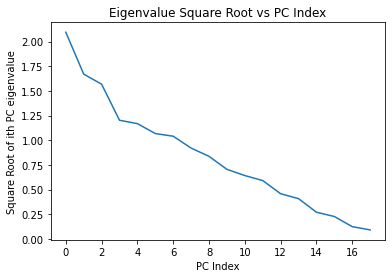

In [36]:
dr = reload(dr)
data_analyzed = dr.pca_analysis(data_v,
                                n_components=data_v.shape[-1],
                                whiten=True,
                                plot_sqrt_eigvals=True)

<Figure size 432x288 with 0 Axes>

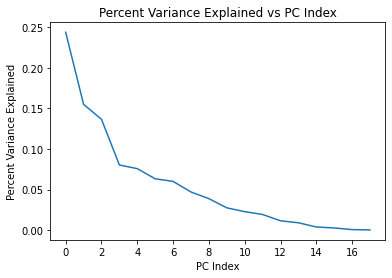

In [37]:
dr.plot_variance_explained(data_analyzed)

In [38]:
data_analyzed["percent_variance_explained_up_to_n_comp"]

array([0.24358275, 0.39851786, 0.53504943, 0.61538891, 0.69121311,
       0.75457606, 0.81475647, 0.86183718, 0.90075796, 0.92839675,
       0.95132215, 0.97077071, 0.98244248, 0.99170941, 0.9957869 ,
       0.99866557, 0.99953143, 1.        ])

In [40]:
axon_data_pca = data_analyzed["data_proj"][axon_indices]
basal_data_pca = data_analyzed["data_proj"][basal_indices]
apical_data_pca = data_analyzed["data_proj"][apical_indices]
data_total_pca = data_analyzed["data_proj"]

In [41]:
# Doing the GMM
K = 4
covariance_type = "full"
curr_data = data_total_pca

st_time = time.time()

#1) Training the GMM
gmm = mixture.GaussianMixture(n_components=K, 
                              covariance_type=covariance_type,
                             reg_covar=0.000001,
                             init_params="kmeans")
gmm.fit(curr_data)

# Getting the Average Log likelihood:
average_log_likelihood_train = gmm.score(curr_data)
print(f"Average Log likelihood = {average_log_likelihood_train}")
print(f"Convergence status = {gmm.converged_}")
print(f"Total time for GMM = {time.time() - st_time}")


Average Log likelihood = -7.832771789605084
Convergence status = True
Total time for GMM = 35.753939628601074


In [42]:
gmm_classification(gmm,data_total_pca)
gmm_classification(gmm,axon_data_pca)
gmm_classification(gmm,basal_data_pca)
gmm_classification(gmm,apical_data_pca)

Classification: Counter({2: 112461, 1: 73319, 3: 50544, 0: 41968})
Classification: Counter({1: 5729, 3: 1615, 2: 977, 0: 464})
Classification: Counter({2: 17844, 1: 8109, 3: 7395, 0: 6544})
Classification: Counter({2: 13020, 1: 6268, 0: 3124, 3: 3066})


array([0, 3, 2, ..., 2, 2, 2])

In [46]:
gmm_means_inverse = data_analyzed["pca_obj"].inverse_transform(gmm.means_)
rec_means = pd.DataFrame(scaler.inverse_transform(gmm_means_inverse))
rec_means.columns = columns_picked
rec_means

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,431.336638,383.198902,2.402287e+01,1.805886e+09,6.842836e+07,5.085130e+04,42821.319965,38.141330,78.359381,364.215671,311.350545,23.864028,1.504725e+09,5.142070e+07,45906.287641,42716.316624,28.655761,76.989951
1,381.798835,381.798835,6.910028e-13,5.078316e-05,3.285706e-06,1.717126e-09,7930.209634,43.940649,91.343552,293.106155,275.916557,12.745740,8.601858e+08,3.146374e+07,18430.554008,33180.309515,44.197874,83.355553
2,455.490224,444.259786,4.570388e+00,3.205405e+08,5.692542e+07,2.099111e+04,13638.538505,38.354037,80.555761,375.936263,330.069393,29.457036,1.925346e+09,4.897791e+07,38893.180862,49368.017154,35.753720,71.643322
3,375.098601,344.533685,1.899059e+01,1.339531e+09,5.009561e+07,3.128333e+04,41324.138641,40.019381,78.595551,170.565612,170.564786,0.000928,8.612391e+04,3.163661e+03,3.748558,7851.463488,68.108268,90.515328


# Try Doing it On PCA (with reduced components)`

In [47]:
data_v = data_total_scaled.to_numpy()
data_v.shape

(278292, 18)

In [48]:
dr = reload(dr)
data_analyzed = dr.pca_analysis(data_v,
                                n_components=4,
                                whiten=True,
                                plot_sqrt_eigvals=False)

n_components = 4
whiten = True
---- Using sklearn method ----


In [49]:
data_analyzed["percent_variance_explained_up_to_n_comp"][3]

0.6153889128340007

In [50]:
axon_data_pca = data_analyzed["data_proj"][axon_indices]
basal_data_pca = data_analyzed["data_proj"][basal_indices]
apical_data_pca = data_analyzed["data_proj"][apical_indices]
data_total_pca = data_analyzed["data_proj"]


In [54]:
# Doing the GMM
K = 4
covariance_type = "full"
curr_data = data_total_pca

st_time = time.time()

#1) Training the GMM
gmm = mixture.GaussianMixture(n_components=K, 
                              covariance_type=covariance_type,
                             reg_covar=0.000001,
                             init_params="kmeans")
gmm.fit(curr_data)

# Getting the Average Log likelihood:
average_log_likelihood_train = gmm.score(curr_data)
print(f"Average Log likelihood = {average_log_likelihood_train}")
print(f"Convergence status = {gmm.converged_}")
print(f"Total time for GMM = {time.time() - st_time}")


Average Log likelihood = -4.707431200587628
Convergence status = True
Total time for GMM = 3.072582960128784


In [55]:
gmm_classification(gmm,data_total_pca)
gmm_classification(gmm,axon_data_pca)
gmm_classification(gmm,basal_data_pca)
gmm_classification(gmm,apical_data_pca)

Classification: Counter({3: 104675, 1: 97111, 0: 49227, 2: 27279})
Classification: Counter({0: 5892, 1: 1818, 3: 780, 2: 295})
Classification: Counter({3: 17354, 1: 13333, 0: 4820, 2: 4385})
Classification: Counter({1: 13323, 3: 9440, 2: 1511, 0: 1204})


array([3, 0, 3, ..., 3, 1, 3])

In [56]:
gmm_means_inverse = data_analyzed["pca_obj"].inverse_transform(gmm.means_)
rec_means = pd.DataFrame(scaler.inverse_transform(gmm_means_inverse))
rec_means.columns = columns_picked
rec_means

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,251.630142,239.559612,8.872889,3.280799e+08,1.752033e+07,-693.748033,27683.567151,49.466815,91.332027,117.596885,120.830542,-0.018422,-1.356118e+08,1.214728e+06,-2952.448923,18180.461785,62.265292,92.535869
1,514.676390,504.698364,2.232804,-6.912737e+07,3.551143e+07,3811.253155,10770.635511,37.478582,84.392364,402.402655,378.584119,7.746533,5.337428e+08,4.517969e+07,27051.590064,19210.631414,38.899431,80.230988
2,361.046783,316.153278,31.648049,3.110650e+09,6.277315e+07,84388.024872,55227.266613,37.598996,73.648596,214.059796,192.234439,7.642660,4.608646e+08,2.096200e+07,18896.358973,17786.256267,51.910893,85.874142
3,421.482599,404.062845,7.627760,6.289586e+08,5.290490e+07,27597.310280,17773.383667,39.179682,80.377336,354.902049,299.578337,40.602264,2.696861e+09,4.725452e+07,43862.578969,66092.548788,34.887273,69.724366


# Get the statistics on the different groups 

In [59]:
# getting the mean of a lot of properties

df_to_analyze = df_filtered[columns_picked]

basal_indices = indices_of_soma_angle(df_filtered,[100,115])
axon_indices = indices_of_soma_angle(df_filtered,[165,180])
apical_indices = indices_of_soma_angle(df_filtered,[0,20])

# Apical Analysis

In [66]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

In [70]:
row

0.0

In [72]:
dir(fig)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_xlabel_grp',
 '_align_ylabel_grp',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_constrained',
 '_constrained_layout_pads',
 '_contains',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_layoutbox',
 '_make_key',
 '_mouseover',
 '_normalize_grid_string',
 '_oid',
 '_path_effects',
 '_picker',
 '_process_projection_requirements',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_repr_html_',
 '

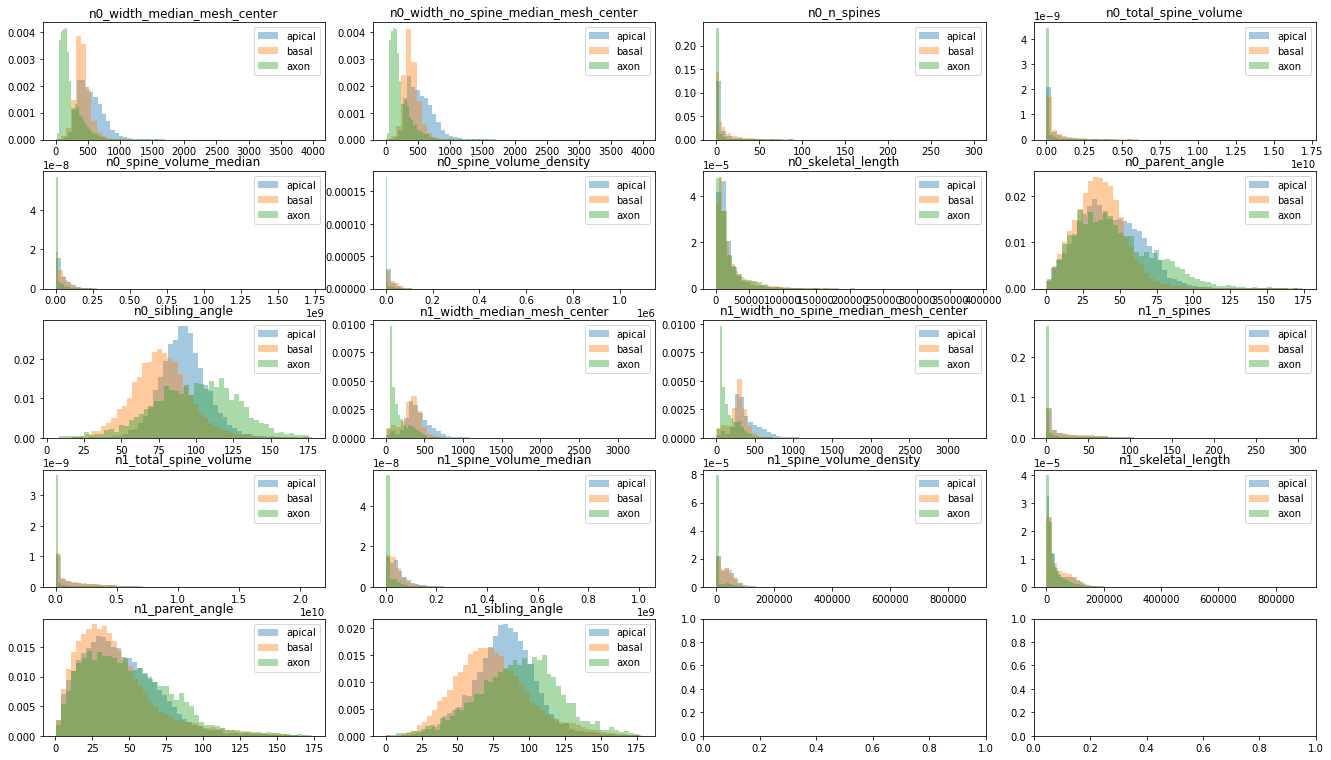

In [82]:
def plot_table_histograms(tables_to_plot,tables_labels,fig_title=None):
    curr_table = apical_table

    fig,axes = plt.subplots(5,4)
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    
    if not fig_title is None:
        fig.title(fig_title)

    
    for j,col_title in enumerate(curr_table):
        row = np.floor(j/4).astype("int")
        column = j - row*4
        ax = axes[row,column]
        ax.set_title(col_title)
        
        for curr_table,curr_table_name in zip(tables_to_plot,tables_labels):
            curr_data = curr_table[col_title].to_numpy()
            ax.hist(curr_data,bins=50,label=curr_table_name,alpha=0.4,density=True)
            
        ax.legend()

        
apical_table = df_to_analyze.iloc[apical_indices]
basal_table = df_to_analyze.iloc[basal_indices]
axon_table = df_to_analyze.iloc[axon_indices]
plot_table_histograms([apical_table,basal_table,axon_table],["apical","basal","axon"])

(array([0.00174422, 0.00454415, 0.00615067, 0.00776867, 0.00957026,
        0.01148661, 0.01456195, 0.01605371, 0.01793563, 0.01932413,
        0.01817661, 0.01631764, 0.01512423, 0.0148603 , 0.01497505,
        0.01456195, 0.01420622, 0.01290953, 0.0125079 , 0.01095875,
        0.00929486, 0.00767686, 0.00611625, 0.00403925, 0.00236388,
        0.00218028, 0.00162947, 0.00117046, 0.00071146, 0.00058523,
        0.00034425, 0.00034425, 0.0002754 , 0.00021803, 0.00011475,
        0.0001377 , 0.0001836 , 0.00012623, 0.00012623, 0.00020655,
        0.00011475, 0.0000918 , 0.0000918 , 0.00006885, 0.00011475,
        0.00011475, 0.00006885, 0.0000459 , 0.00002295, 0.0000459 ]),
 array([  0.14  ,   3.5604,   6.9808,  10.4012,  13.8216,  17.242 ,
         20.6624,  24.0828,  27.5032,  30.9236,  34.344 ,  37.7644,
         41.1848,  44.6052,  48.0256,  51.446 ,  54.8664,  58.2868,
         61.7072,  65.1276,  68.548 ,  71.9684,  75.3888,  78.8092,
         82.2296,  85.65  ,  89.0704,  92.4908

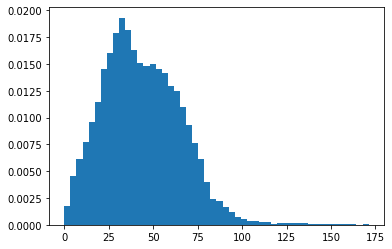

In [83]:
plt.hist(apical_table["n0_parent_angle"].to_numpy(),density=True,bins=50)

# Variational Inference

In [1]:
from os import sys
sys.path.append("/notebooks/Neurosignal_Final/PRML/")

In [2]:
from prml.rv import VariationalGaussianMixture

In [3]:
vgmm = VariationalGaussianMixture(n_components=6)